In [33]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import tensorflow as tf
from kerastuner import RandomSearch
import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration and Visualization

In [4]:
chemical = pd.read_parquet("data/chemical_composition_data.parquet")
corrosion = pd.read_parquet("data/corrosion_wear_data.parquet")
environmental = pd.read_parquet("data/environmental_data.parquet")
fluid = pd.read_parquet("data/fluid_flow_data.parquet")
seismic = pd.read_parquet("data/seismic_data.parquet")
temperature_pressure = pd.read_parquet("data/temperature_pressure_data.parquet")

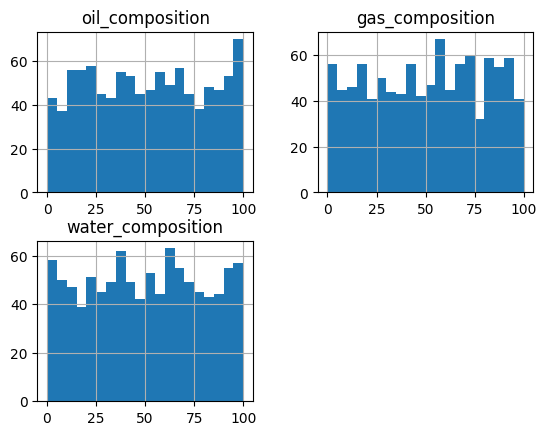

In [5]:
chemical[['oil_composition', 'gas_composition', 'water_composition']].hist(bins=20)
plt.show()


corrosion_rate    5.038482
wear_rate         4.843135
dtype: float64


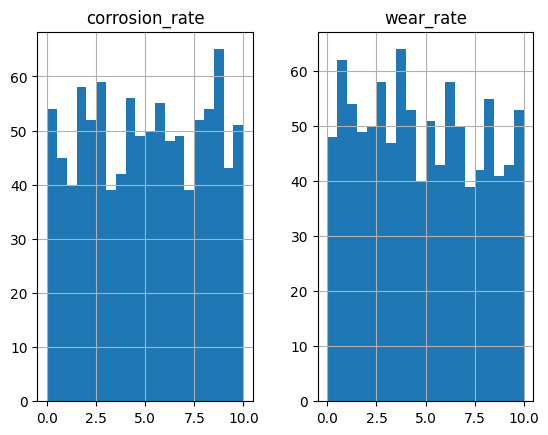

In [6]:
print(corrosion[['corrosion_rate', 'wear_rate']].mean())
corrosion[['corrosion_rate', 'wear_rate']].hist(bins=20)
plt.show()


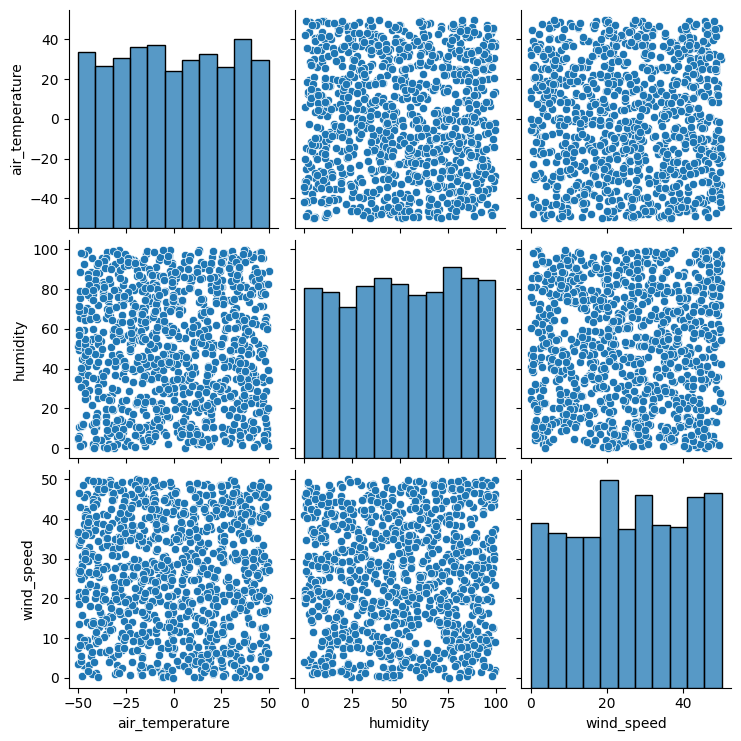

In [7]:
sns.pairplot(environmental[['air_temperature', 'humidity', 'wind_speed']])
plt.show()


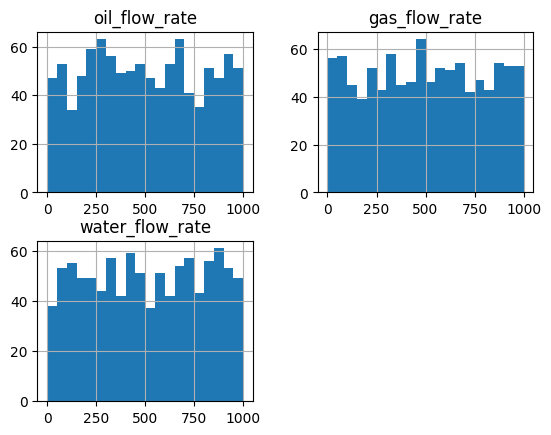

In [8]:
fluid[['oil_flow_rate', 'gas_flow_rate', 'water_flow_rate']].hist(bins=20)
plt.show()


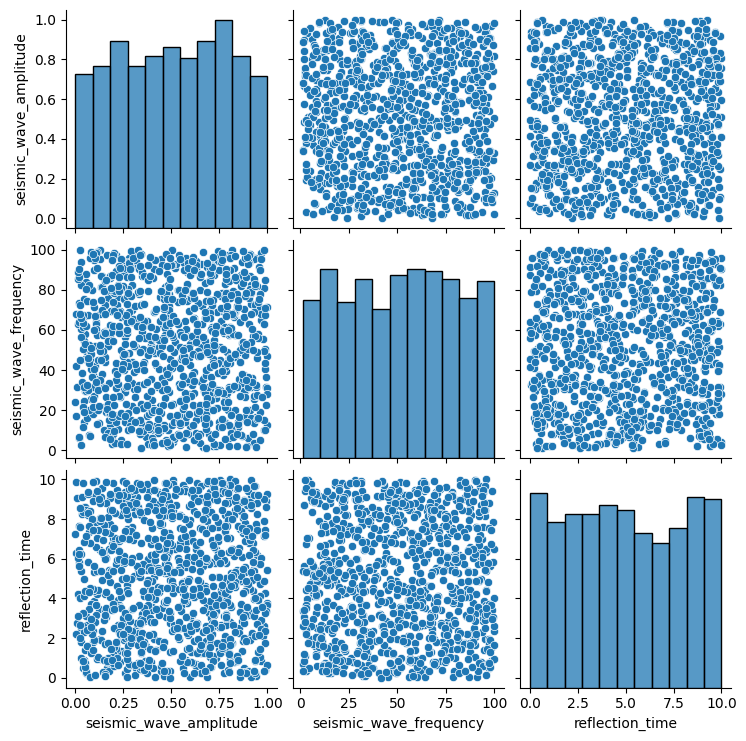

In [9]:
sns.pairplot(seismic[['seismic_wave_amplitude', 'seismic_wave_frequency', 'reflection_time']])
plt.show()


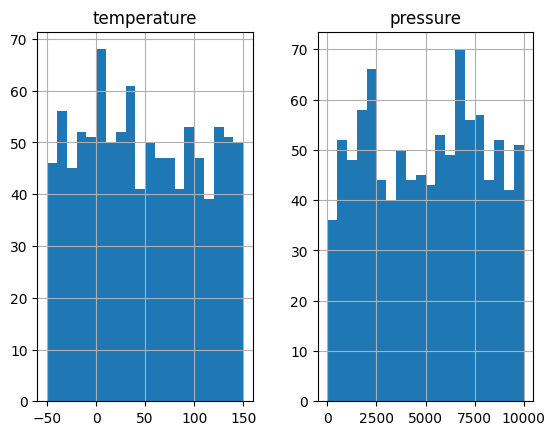

In [10]:
temperature_pressure[['temperature', 'pressure']].hist(bins=20)
plt.show()


In [11]:
print(chemical.describe())
print(corrosion.describe())
print(environmental.describe())
print(fluid.describe())
print(seismic.describe())
print(temperature_pressure.describe())


         sample_id  oil_composition  gas_composition  water_composition
count  1000.000000      1000.000000      1000.000000        1000.000000
mean    498.708000        50.559000        50.631393          50.220426
std     283.491492        29.211228        28.856332          28.996182
min       1.000000         0.000000         0.003786           0.138364
25%     253.000000        24.750000        25.490763          25.478860
50%     492.500000        50.000000        52.700602          50.701672
75%     744.250000        75.250000        74.318242          74.403045
max     998.000000       100.000000        99.931785          99.909585
         sensor_id  corrosion_rate    wear_rate
count  1000.000000     1000.000000  1000.000000
mean    491.197000        5.038482     4.843135
std     295.161489        2.900468     2.879760
min       2.000000        0.000529     0.002915
25%     227.500000        2.507623     2.376131
50%     497.500000        5.080561     4.692435
75%     741.5000

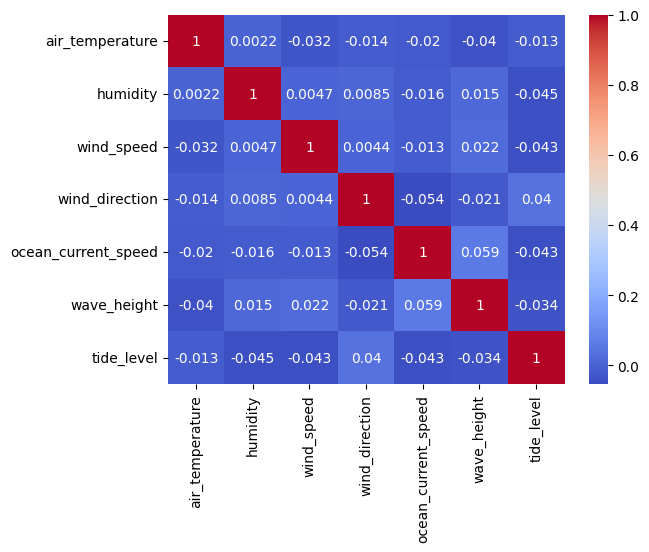

In [12]:
# Example for environmental data
correlations = environmental.corr()
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.show()

## 2. Feature Engineering

In [13]:
def engineer_features(df, sensor_value_columns):
    for sensor_value_column in sensor_value_columns:
        # Normalize sensor readings
        scaler = MinMaxScaler()
        df[f'normalized_{sensor_value_column}'] = scaler.fit_transform(df[[sensor_value_column]])

        # Create rolling window features
        df[f'{sensor_value_column}_rolling_mean'] = df[sensor_value_column].rolling(window=5).mean()
        df[f'{sensor_value_column}_rolling_std'] = df[sensor_value_column].rolling(window=5).std()

        # Create lag features
        df[f'{sensor_value_column}_lag_1'] = df[sensor_value_column].shift(1)
        df[f'{sensor_value_column}_lag_2'] = df[sensor_value_column].shift(2)
        
    return df

# Example usage: apply the engineer_features function to each sensor dataframe
chemical_engineered = engineer_features(chemical, ['oil_composition', 'gas_composition', 'water_composition'])
corrosion_engineered = engineer_features(corrosion, ['corrosion_rate', 'wear_rate'])
environmental_engineered = engineer_features(environmental, ['air_temperature', 'humidity', 'wind_speed', 'wind_direction', 'ocean_current_speed', 'wave_height', 'tide_level'])
fluid_engineered = engineer_features(fluid, ['oil_flow_rate', 'gas_flow_rate', 'water_flow_rate'])
seismic_engineered = engineer_features(seismic, ['seismic_wave_amplitude', 'seismic_wave_frequency', 'reflection_time'])
temperature_pressure_engineered = engineer_features(temperature_pressure, ['temperature', 'pressure'])


## 3. Data Pre-Processing

In [24]:
def preprocess_data(df, sensor_value_columns):
    # Handle missing values - fill with mean
    for column in sensor_value_columns:
        df[column].fillna(df[column].mean(), inplace=True)

    # Handle outliers - using the Z-score method
    z_scores = np.abs(stats.zscore(df[sensor_value_columns]))
    threshold = 3  # Z-score threshold for considering a data point as an outlier
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]

    # Scale and normalize the data
    scaler = StandardScaler()
    df_no_outliers[sensor_value_columns] = scaler.fit_transform(df_no_outliers[sensor_value_columns])

    return df_no_outliers

# Apply the preprocess_data function to each sensor dataframe
chemical_preprocessed = preprocess_data(chemical_engineered, ['oil_composition', 'gas_composition', 'water_composition']).dropna().drop("sample_id", axis = 1)
corrosion_preprocessed = preprocess_data(corrosion_engineered, ['corrosion_rate', 'wear_rate']).dropna().drop("sensor_id", axis = 1)
environmental_preprocessed = preprocess_data(environmental_engineered, ['air_temperature', 'humidity', 'wind_speed', 'wind_direction', 'ocean_current_speed', 'wave_height', 'tide_level']).dropna()
fluid_preprocessed = preprocess_data(fluid_engineered, ['oil_flow_rate', 'gas_flow_rate', 'water_flow_rate']).dropna().drop("sensor_id", axis = 1)
seismic_preprocessed = preprocess_data(seismic_engineered, ['seismic_wave_amplitude', 'seismic_wave_frequency', 'reflection_time']).dropna().drop("geophone_id", axis = 1)
temperature_pressure_preprocessed = preprocess_data(temperature_pressure_engineered, ['temperature', 'pressure']).dropna().drop("sensor_id", axis = 1)


In [26]:
chemical_preprocessed

,oil_composition,gas_composition,water_composition,normalized_oil_composition,oil_composition_rolling_mean,oil_composition_rolling_std,oil_composition_lag_1,oil_composition_lag_2,normalized_gas_composition,gas_composition_rolling_mean,gas_composition_rolling_std,gas_composition_lag_1,gas_composition_lag_2,normalized_water_composition,water_composition_rolling_mean,water_composition_rolling_std,water_composition_lag_1,water_composition_lag_2
4,1.693381,-1.649146,-1.407917,1.00,67.2,22.219361,71.0,38.0,0.030653,44.446788,47.533820,12.881147,99.551339,0.092995,33.812961,25.539572,13.786798,69.904401
5,0.700115,-0.815635,0.384623,0.71,68.4,22.232859,100.0,71.0,0.271227,31.278266,39.111896,3.066880,12.881147,0.613695,36.143183,27.786066,9.416614,13.786798
6,-1.320667,0.694523,0.509789,0.12,58.4,33.974991,71.0,100.0,0.707099,42.653809,40.978875,27.106915,3.066880,0.650053,43.894047,29.674261,61.367461,9.416614
7,1.111122,-0.087726,-0.396632,0.83,67.4,33.170770,12.0,71.0,0.481321,32.363782,27.294664,70.662765,27.106915,0.386755,37.658240,25.874685,64.994959,61.367461
8,-0.293150,-0.119865,1.474351,0.42,61.6,34.875493,83.0,12.0,0.472045,39.222403,25.419324,48.101201,70.662765,0.930241,53.490800,31.272735,38.725370,64.994959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.772658,-0.675428,0.353309,0.28,46.8,33.432021,96.0,15.0,0.311694,45.823988,26.676467,68.615969,22.360446,0.604599,62.269689,22.951600,27.559518,84.842901
996,-0.532904,-1.640331,-0.352445,0.35,48.0,32.733775,28.0,96.0,0.033197,30.415876,23.838664,31.150754,68.615969,0.399590,54.004725,21.782462,60.459909,27.559518
997,0.460362,-1.511701,-0.476609,0.64,47.6,32.469986,35.0,28.0,0.070323,26.495869,26.119057,3.321119,31.150754,0.363523,49.855161,22.975771,40.005977,60.459909
998,-0.669906,-0.887085,-0.510482,0.31,50.8,29.063723,64.0,35.0,0.250604,27.033013,26.040247,7.031057,3.321119,0.353683,39.971741,12.320703,36.407501,40.005977


## 4. Model Selection

In [37]:
def train_isolation_forest(df):
    model = IsolationForest(contamination=0.01, max_features= 1, max_samples= "auto", n_estimators=50, random_state=42)
    model.fit(df)
    return model

# Train Isolation Forest models for each sensor dataframe
isolation_forest_chemical = train_isolation_forest(chemical_preprocessed)
isolation_forest_corrosion = train_isolation_forest(corrosion_preprocessed)
isolation_forest_environmental = train_isolation_forest(environmental_preprocessed)
isolation_forest_fluid = train_isolation_forest(fluid_preprocessed)
isolation_forest_seismic = train_isolation_forest(seismic_preprocessed)
isolation_forest_temperature_pressure = train_isolation_forest(temperature_pressure_preprocessed)

def detect_anomalies_isolation_forest(df, model):
    anomaly_scores = model.decision_function(df)
    anomaly_predictions = model.predict(df)
    return anomaly_scores, anomaly_predictions

# Detect anomalies in each sensor dataframe using Isolation Forest
chemical_anomaly_scores_if, chemical_anomaly_predictions_if = detect_anomalies_isolation_forest(chemical_preprocessed, isolation_forest_chemical)
corrosion_anomaly_scores_if, corrosion_anomaly_predictions_if = detect_anomalies_isolation_forest(corrosion_preprocessed, isolation_forest_corrosion)
environmental_anomaly_scores_if, environmental_anomaly_predictions_if = detect_anomalies_isolation_forest(environmental_preprocessed, isolation_forest_environmental)
fluid_anomaly_scores_if, fluid_anomaly_predictions_if = detect_anomalies_isolation_forest(fluid_preprocessed, isolation_forest_fluid)
seismic_anomaly_scores_if, seismic_anomaly_predictions_if = detect_anomalies_isolation_forest(seismic_preprocessed, isolation_forest_seismic)
temperature_pressure_anomaly_scores_if, temperature_pressure_anomaly_predictions_if = detect_anomalies_isolation_forest(temperature_pressure_preprocessed, isolation_forest_temperature_pressure)

# Best parameters for Isolation Forest:
#  {'contamination': 0.01, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 50}

In [38]:
chemical_anomaly_scores_if

array([ 6.10894721e-02,  4.35823054e-02,  5.11407291e-02,  3.81004478e-02,
        4.31055703e-02,  6.21210549e-02,  3.93149724e-02,  7.23677634e-02,
        6.74493049e-02,  4.71332631e-02,  6.54062389e-02,  4.76837076e-02,
        4.14447058e-02,  6.07109680e-02,  5.33951797e-02,  4.26035166e-02,
        3.42063966e-02,  4.88736219e-02,  4.90444354e-02,  3.12264345e-02,
        2.57677963e-02,  4.87938952e-02,  5.14352623e-02,  3.41622861e-02,
        3.78919727e-02,  2.09448728e-02,  2.43012626e-02,  3.91383349e-02,
        3.01908353e-02,  5.65579354e-02,  1.57742427e-02,  2.47074074e-02,
        4.14063300e-02,  5.92455339e-02,  8.44155061e-02,  5.69399247e-02,
        4.62219458e-02,  5.10635941e-02,  4.25491045e-02,  5.55848648e-02,
        3.56349116e-02,  6.20129680e-02,  5.80298994e-02,  2.82989134e-02,
        5.56233374e-02,  2.48420922e-02,  6.60585339e-02,  4.04436369e-02,
        6.53155050e-02,  4.55791391e-02,  5.72270960e-02,  4.27578916e-02,
        1.99969787e-02,  

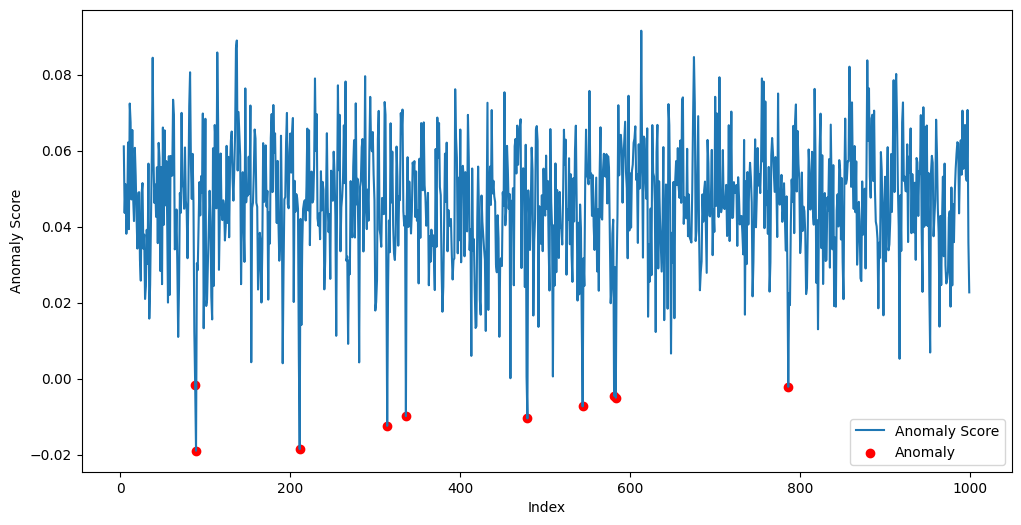

In [39]:
def plot_anomaly_scores(df, anomaly_scores, anomaly_predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, anomaly_scores, label='Anomaly Score')
    plt.scatter(df.index[anomaly_predictions == -1], anomaly_scores[anomaly_predictions == -1], color='r', marker='o', label='Anomaly')
    plt.xlabel('Index')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.show()

# Plot the anomaly scores and detected anomalies for the chemical_preprocessed dataframe
plot_anomaly_scores(chemical_preprocessed, chemical_anomaly_scores_if, chemical_anomaly_predictions_if)


In [30]:
def train_autoencoder(df):
    input_dim = df.shape[1]
    encoding_dim = int(input_dim / 2)
    
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="tanh")(input_layer)
    decoder = Dense(input_dim, activation="linear")(encoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    autoencoder.fit(df, df, epochs=100, batch_size=32, shuffle=True, verbose=0)

    return autoencoder

# Train Autoencoder models for each sensor dataframe
autoencoder_chemical = train_autoencoder(chemical_preprocessed)
autoencoder_corrosion = train_autoencoder(corrosion_preprocessed)
autoencoder_environmental = train_autoencoder(environmental_preprocessed)
autoencoder_fluid = train_autoencoder(fluid_preprocessed)
autoencoder_seismic = train_autoencoder(seismic_preprocessed)
autoencoder_temperature_pressure = train_autoencoder(temperature_pressure_preprocessed)

import numpy as np

def detect_anomalies_autoencoder(df, model, threshold=1.5):
    predictions = model.predict(df)
    mse = np.mean(np.power(df - predictions, 2), axis=1)
    anomalies = mse > threshold
    return mse, anomalies

# Detect anomalies in each sensor dataframe using Autoencoder
chemical_anomaly_scores_ae, chemical_anomaly_predictions_ae = detect_anomalies_autoencoder(chemical_preprocessed, autoencoder_chemical)
corrosion_anomaly_scores_ae, corrosion_anomaly_predictions_ae = detect_anomalies_autoencoder(corrosion_preprocessed, autoencoder_corrosion)
environmental_anomaly_scores_ae, environmental_anomaly_predictions_ae = detect_anomalies_autoencoder(environmental_preprocessed, autoencoder_environmental)
fluid_anomaly_scores_ae, fluid_anomaly_predictions_ae = detect_anomalies_autoencoder(fluid_preprocessed, autoencoder_fluid)
seismic_anomaly_scores_ae, seismic_anomaly_predictions_ae = detect_anomalies_autoencoder(seismic_preprocessed, autoencoder_seismic)
temperature_pressure_anomaly_scores_ae, temperature_pressure_anomaly_predictions_ae = detect_anomalies_autoencoder(temperature_pressure_preprocessed, autoencoder_temperature_pressure)


2023-04-07 18:07:06.506819: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


32/32 [==============================] - 0s 316us/step


## 5. Model Tuning

In [ ]:
# Define the parameter grid for Isolation Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 256, 512],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [1, 2, 3]
}

# Create an Isolation Forest model
isolation_forest = IsolationForest()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(isolation_forest, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

# Train the model using the preprocessed data without the sample_id column
grid_search.fit(chemical_preprocessed)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters for Isolation Forest:", best_params)


In [40]:
# Define the Autoencoder model builder function
def build_autoencoder_model(hp):
    model = tf.keras.Sequential()
    
    # Encoder
    model.add(tf.keras.layers.Dense(hp.Int('encoder_units', min_value=8, max_value=64, step=8), activation='relu', input_shape=(chemical_preprocessed.shape[1],)))
    
    # Decoder
    model.add(tf.keras.layers.Dense(chemical_preprocessed.shape[1], activation='linear'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='mse')
    
    return model

# Initialize the Keras Tuner object
tuner = RandomSearch(
    build_autoencoder_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='autoencoder_tuning',
    project_name='chemical_autoencoder'
)

# Train the model using the preprocessed data without the sample_id column
X_train, X_val = train_test_split(chemical_preprocessed, test_size=0.2, random_state=42)
tuner.search(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get the best parameters
best_params = tuner.get_best_hyperparameters()[0]

Trial 10 Complete [00h 00m 07s]
val_loss: 60.612135887145996

Best val_loss So Far: 0.038664307445287704
Total elapsed time: 00h 00m 58s
INFO:tensorflow:Oracle triggered exit
